In [59]:
import time
from pathlib import Path

import numpy as np
from numba import njit, prange

from matplotlib import pyplot as plt

### Load data

In [60]:
train_data = np.loadtxt(Path('/mnt/HDD500GB/Data/development/jupyterLab/data/mnist_train_small.csv'), delimiter=',')
test_data = np.loadtxt(Path('/mnt/HDD500GB/Data/development/jupyterLab/data/mnist_test.csv'), delimiter=',')

In [61]:
x_train = train_data[:,1:] / 255.0
x_test = test_data[:,1:] / 255.0

In [62]:
img_shape = (28, 28)
img_size = 784

### Define activation functions

In [63]:
@njit(fastmath=True)
def ReLU(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def dRelu(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)


@njit(fastmath=True)
def Sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)

### Define model

In [64]:
@njit(fastmath=True)
def grads(xbatch: np.ndarray, V: np.ndarray, c: np.ndarray, W: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    dV = np.zeros(V.shape)
    dc = np.zeros(c.shape)

    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    for i in prange(xbatch.shape[0]):
        h = V @ xbatch[i] + c
        z = ReLU(h)
        y = W @ z + b

        dLdy = 2 * (y - xbatch[i])
        dLdh = W.T @ dLdy * dRelu(h)

        dW += np.outer(dLdy, z)
        db += dLdy

        dV += np.outer(dLdh, xbatch[i])
        dc += dLdh

    return (dV, dc, dW, db)

class Autoencoder:
    def __init__(self, nIn: int, nHidden: int) -> None:
        self.nIn = nIn
        self.nHidden = nHidden
        
        self.V: np.ndarray = np.random.uniform(-1, 1, (nHidden, nIn))
        self.c: np.ndarray = np.zeros((nHidden,))

        self.W: np.ndarray = np.random.uniform(-1, 1, (nIn, nHidden))
        self.b: np.ndarray = np.zeros((nIn,))

    def predict(self, x:np.ndarray) -> np.ndarray:
        z = ReLU(self.V @ x + self.c)
        return self.W @ z + self.b

    def loss(self, x: np.ndarray) -> float:        
        xpred = np.array([self.predict(xi) for xi in x])
        h = np.linalg.norm(xpred - x, axis=1)
        return np.mean(h)

    def train(self, xTrain: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = xTrain.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for i in range(n // batch_size):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dV, dc, dW, db = grads(xTrain[batch_idxs], self.V, self.c, self.W, self.b)

                self.V -= lr * dV
                self.c -= lr * dc
                
                self.W -= lr * dW
                self.b -= lr * db

### Create and train model

In [66]:
nIn = 784
nHidden = 16

learning_rate = 1e-2
batch_size = 64
max_epoch = 32

model = Autoencoder(nIn, nHidden)

print('untrained loss: ', model.loss(x_test).round(3))

time_begin = time.time()

model.train(x_train, learning_rate, batch_size, max_epoch)

time_end = time.time()
training_time = round(time_end - time_begin, 2)

print(f'trained loss: {model.loss(x_test).round(3)}')
print(f'training time: {training_time} sec.')

untrained loss:  253.548
trained loss:  7.267
training time: 68.99 sec.


### Visualize model's learned features

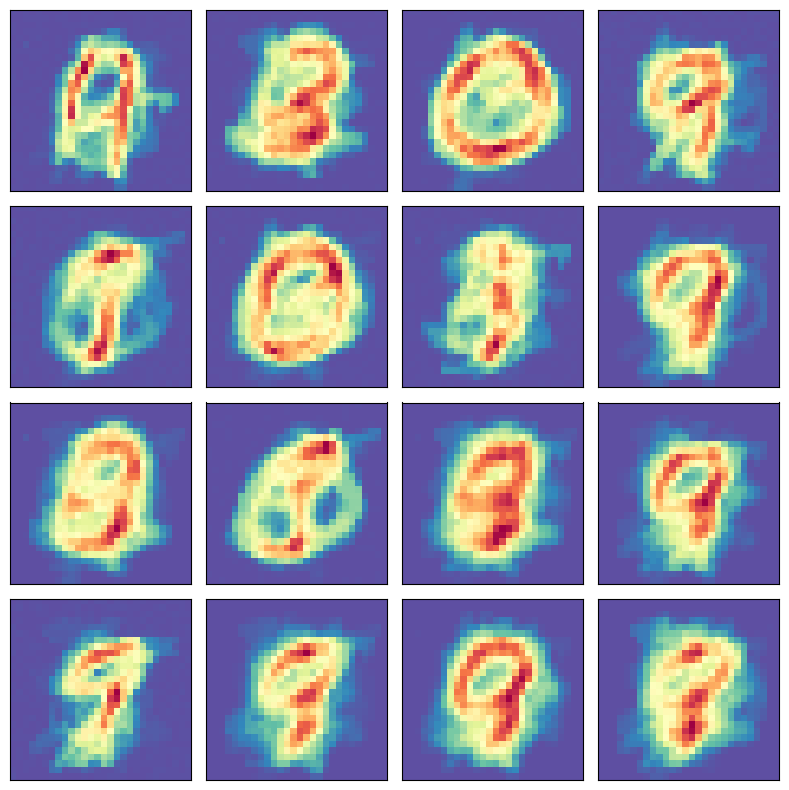

In [79]:
fig, axes = plt.subplots(nrows=4, ncols=4)

fig.set_dpi(100)
fig.set_figwidth(8)
fig.set_figheight(8)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(model.V[i].reshape(img_shape),  cmap='Spectral')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()